In [4]:
%matplotlib inline


nn.Transformer와 torchtext로 언어 번역하기
======================================================

- 이 튜토리얼에서는 Transformer(트랜스포머)를 사용한 번역 모델을 바닥부터 학습하는 방법을 배워보겠습니다.
- [Multi30k](http://www.statmt.org/wmt16/multimodal-task.html#task1) 
  데이터셋을 사용하여 독일어(German)를 영어(English)로 번역하는 모델을 학습해보겠습니다.


데이터 구하고 처리하기
----------------------------

[torchtext 라이브러리](https://pytorch.org/text/stable/) 에는 언어 번역 모델을
생성하기 위한 데이터셋을 쉽게 만들 수 있는 도구들이 있습니다.
이 튜토리얼에서는 torchtext의 내장(inbuilt) 데이터셋을 어떻게 사용하고,
원시(raw) 텍스트 문장을 토큰화(tokenize)하고, 토큰을 텐서로 수치화하는 방법을
살펴보겠습니다. 출발어(source)-도착어(target) 원시(raw) 문장을 생성하기 위해서는
torchtext 라이브러리의 [Multi30k 데이터셋](https://pytorch.org/text/stable/datasets.html#multi30k)
을 사용하겠습니다.





- (추가) `spaCy`를 활용한 Tokenization
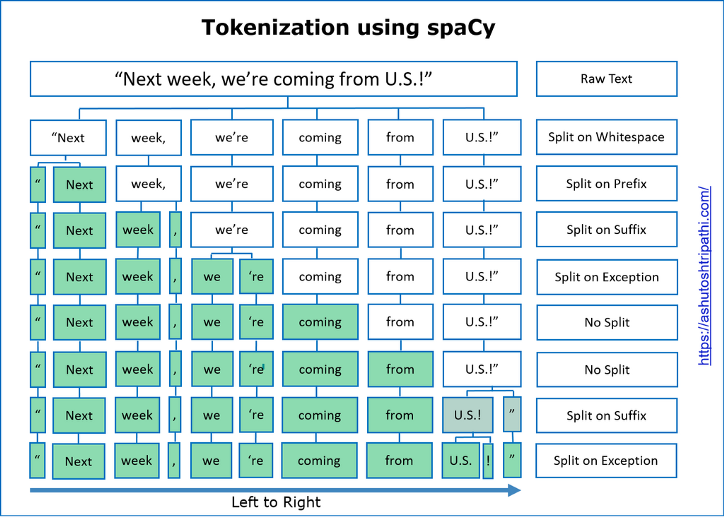

In [5]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List


SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# 출발어(source)와 목적어(target)의 토크나이저(tokenizer)를 생성합니다.
# 아래 필요 사항(dependency)을 모두 설치해주세요.
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm
# 위 dependency 설치 후 Colab 런타임 다시 시작(ctrl+M)
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

# 토큰 목록을 생성하기 위한 헬퍼(helper) 함수
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# 특수 기호(symbol)와 인덱스를 정의합니다
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# 토큰들이 어휘집(vocab)에 인덱스 순서대로 잘 삽입되어 있는지 확인합니다
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>'] # Unknown, Padding, Beginning of the Seq, End of the Seq

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # 학습용 데이터 반복자(iterator)
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # torchtext의 Vocab(어휘집) 객체 생성
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1, # Vocabulary에 추가될 단어의 최소한의 단어 빈도
                                                    specials=special_symbols)

# UNK_IDX를 기본 인덱스로 설정합니다. 이 인덱스는 토큰을 찾지 못하는 경우에 반환됩니다.
# 만약 기본 인덱스를 설정하지 않으면 어휘집(Vocabulary)에서 토큰을 찾지 못하는 경우
# RuntimeError가 발생합니다.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

Transformer를 사용한 시퀀스-투-시퀀스(Seq2Seq) 신경망
------------------------------------------------------------

Transformer(트랜스포머)는 기계번역 작업(task)을 위해
[Attention is all you need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
논문에 소개된 Seq2Seq 모델입니다.
아래에서 Transformer를 사용한 Seq2Seq 신경망을 만들어보겠습니다.
신경망은 세 부분으로 구성되는데, 첫번째 부분은 임베딩 계층(embedding layer)입니다.
이 계층은 입력 인덱스의 텐서를 입력 임베딩의 해당하는 텐서로 변환합니다.
이러한 임베딩은 입력 토큰의 위치 정보(position information)를 모델에 전달하기 위해
위치 인코딩(positional encoding)을 추가합니다.
두번째 부분은 실제 [Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) 모델입니다.
마지막으로 Transformer 모델의 출력을 선형 계층에 통과시켜 도착어의 각 토큰에 대한 확률을 제공합니다.




In [6]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 단어 순서 개념(notion)을 토큰 임베딩에 도입하기 위한 위치 인코딩(positional encoding)을 위한 헬퍼 모듈(Module)
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# 입력 인덱스의 텐서를 해당하는 토큰 임베딩의 텐서로 변환하기 위한 헬퍼 모듈(Module)
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size) # Embedding layer를 만들어 학습 데이터로부터 처음부터 embedding vector를 학습시키기 위한 Embedding layer 정의
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size) # Positional encoding을 상대적으로 작게 만들기 위해 Embedding size의 제곱근을 곱해줌

# Seq2Seq 신경망
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

학습하는 동안, 모델이 예측하는 동안 정답(이후 출현하는 단어)을 보지 못하도록 하는
후속 단어 마스크(subsequent word mask)가 필요합니다. 또한, 출발어와 도착어의 패딩(padding) 토큰들
또한 숨겨야 합니다. 아래에 두 가지 모두를 처리할 함수를 정의해보겠습니다.




In [7]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1) # torch.triu : matrix 값의 lower triangular part를 0값을로 채움
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

이제 모델의 매개변수를 정의하고 객체를 생성(instantiate)해보겠습니다.
아래처럼 학습 단계에서 사용할 손실 함수(loss function)를 교차 엔트로피 손실(cross-entropy loss)로 정의하고,
옵티마이저(optimizer)도 정의합니다.




In [8]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

대조(Collation)
-----------------

위의 ``데이터 구하고 처리하기`` 장에서 봤듯이, 데이터 반복자(iterator)는 원시 문자열의 쌍을 생성합니다.
이 문자열 쌍들을 이전에 정의한 ``Seq2Seq`` 신경망에서 처리할 수 있도록 텐서 묶음(batched tensor)으로 변환해야 합니다.
이제 원시 문자열들의 묶음(batch)을 텐서 묶음으로 변환하여 모델에 직접 전달할 수 있도록 하는 대응어(collate) 함수를
정의해보겠습니다.




In [9]:
from torch.nn.utils.rnn import pad_sequence

# 순차적인 작업들을 하나로 묶는 헬퍼 함수
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# BOS/EOS를 추가하고 입력 순서(sequence) 인덱스에 대한 텐서를 생성하는 함수
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# 출발어(src)와 도착어(tgt) 원시 문자열들을 텐서 인덱스로 변환하는 변형(transform)
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # 토큰화(Tokenization)
                                               vocab_transform[ln], # 수치화(Numericalization)
                                               tensor_transform) # BOS/EOS를 추가하고 텐서를 생성


# 데이터를 텐서로 조합(collate)하는 함수
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))) # 오른쪽에서 줄바꿈 기호 제거
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

각 에폭(epoch)마다 호출할 학습 및 검증(evaluation) 단계를 정의해보겠습니다.




In [10]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for i, (src, tgt) in enumerate(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
        # print("Batch " + str(i+1) + " / " + str(len(train_dataloader)) + " loss : ", loss.item())

    return losses / len(train_dataloader)


def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

이제 모델 학습을 위한 모든 요소가 준비되었습니다. 학습을 해보겠습니다!




In [11]:
from timeit import default_timer as timer
# NUM_EPOCHS = 1
NUM_EPOCHS = 18

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


# 탐욕(greedy) 알고리즘을 사용하여 출력 순서(sequence)를 생성하는 함수
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# 입력 문장을 도착어로 번역하는 함수
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

100%|██████████| 46.3k/46.3k [00:00<00:00, 224kB/s]


Epoch: 1, Train loss: 5.344, Val loss: 4.135, Epoch time = 84.277s
Epoch: 2, Train loss: 3.793, Val loss: 3.358, Epoch time = 83.992s
Epoch: 3, Train loss: 3.180, Val loss: 2.923, Epoch time = 83.830s
Epoch: 4, Train loss: 2.778, Val loss: 2.639, Epoch time = 83.821s
Epoch: 5, Train loss: 2.489, Val loss: 2.458, Epoch time = 83.914s
Epoch: 6, Train loss: 2.258, Val loss: 2.318, Epoch time = 83.914s
Epoch: 7, Train loss: 2.066, Val loss: 2.217, Epoch time = 83.956s
Epoch: 8, Train loss: 1.904, Val loss: 2.138, Epoch time = 83.707s
Epoch: 9, Train loss: 1.762, Val loss: 2.055, Epoch time = 83.709s
Epoch: 10, Train loss: 1.633, Val loss: 2.004, Epoch time = 83.760s
Epoch: 11, Train loss: 1.522, Val loss: 1.985, Epoch time = 83.651s
Epoch: 12, Train loss: 1.431, Val loss: 1.976, Epoch time = 83.701s
Epoch: 13, Train loss: 1.338, Val loss: 1.953, Epoch time = 83.619s
Epoch: 14, Train loss: 1.252, Val loss: 1.933, Epoch time = 83.763s
Epoch: 15, Train loss: 1.171, Val loss: 1.927, Epoch time

In [12]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people in an office setting . 


참고자료
----------

1. Attention is all you need 논문.
   https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf
2. Transformer에 대한 설명. https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding


